In [246]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [247]:
#Parameters


#MACD parameters
n = 9
m = 19
t = 6

#RSI parameters
period = 14

In [248]:
dataimport = pd.read_csv('/Users/hitengoel/Machine Learning/data analysis(technical indiactors)/data-analysis-with-technical-indicators/Pair Trading final/data/Indexes/DOW JONES.csv')


dataimport['Date'] = pd.to_datetime(dataimport['Date'])
dataimport.set_index('Date', inplace=True)
data = dataimport.resample('W').first()  # Weekly Resampling

data.reset_index(inplace=True)
data['Date'] = data['Date'].astype(str)
stock_names = data.columns[1:]

datacopy = data.copy()

data

,Date,UNH UN Equity,GS UN Equity,MSFT UQ Equity,HD UN Equity,CAT UN Equity,AMGN UQ Equity,MCD UN Equity,CRM UN Equity,BA UN Equity,...,JPM UN Equity,IBM UN Equity,MRK UN Equity,NKE UN Equity,MMM UN Equity,DIS UN Equity,KO UN Equity,CSCO UQ Equity,INTC UQ Equity,VZ UN Equity
0,2011-01-09,37.13,173.05,27.980,35.31,94.15,55.55,76.60,34.1500,66.40,...,43.58,140.8676,34.3651,21.5225,86.79,37.82,32.610,20.49,20.850,36.43
1,2011-01-16,38.45,169.76,28.210,34.39,93.39,56.44,73.56,35.6600,69.09,...,43.40,141.0204,35.4712,21.0425,87.15,39.50,31.530,20.78,20.690,35.92
2,2011-01-23,40.77,175.00,28.300,35.89,94.01,56.50,74.06,36.6175,70.07,...,44.91,143.2746,32.6392,21.0175,88.10,39.29,31.565,21.21,21.080,35.46
3,2011-01-30,39.81,166.30,28.380,36.65,94.57,57.29,75.38,31.9575,72.73,...,45.02,152.4728,32.2292,20.6650,90.32,39.94,31.625,21.17,21.240,35.24
4,2011-02-06,41.05,163.62,27.725,36.77,97.01,55.08,73.67,32.2850,69.48,...,44.94,154.7366,31.6285,20.6200,87.92,38.87,31.425,21.15,21.460,35.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2022-12-04,532.27,382.36,241.760,318.92,232.30,282.62,272.88,153.6900,171.83,...,134.35,146.1800,108.4500,104.9600,124.64,95.69,62.700,48.08,28.725,38.24
622,2022-12-11,535.04,371.54,250.200,320.08,232.57,284.91,271.59,133.9300,185.10,...,131.37,147.4100,110.0100,109.6200,124.63,95.93,63.470,49.33,29.170,37.07
623,2022-12-18,545.86,363.18,252.510,327.98,233.06,276.78,276.62,133.1100,186.27,...,134.21,149.2100,108.9700,112.0700,126.85,94.66,63.970,49.30,28.690,37.95
624,2022-12-25,523.60,344.61,240.450,317.33,232.29,265.70,265.83,129.0100,185.68,...,130.06,138.8700,109.4400,103.0500,122.13,85.78,62.840,47.40,26.790,37.03


In [249]:
data.dtypes

Date               object
UNH UN Equity     float64
GS UN Equity      float64
MSFT UQ Equity    float64
HD UN Equity      float64
CAT UN Equity     float64
AMGN UQ Equity    float64
MCD UN Equity     float64
CRM UN Equity     float64
BA UN Equity      float64
AAPL UQ Equity    float64
CVX UN Equity     float64
TRV UN Equity     float64
WMT UN Equity     float64
JNJ UN Equity     float64
AXP UN Equity     float64
PG UN Equity      float64
JPM UN Equity     float64
IBM UN Equity     float64
MRK UN Equity     float64
NKE UN Equity     float64
MMM UN Equity     float64
DIS UN Equity     float64
KO UN Equity      float64
CSCO UQ Equity    float64
INTC UQ Equity    float64
VZ UN Equity      float64
dtype: object

## Strat-1 MACD + RSI

In [250]:
def MACD(price_data, short_window, long_window, signal_window, column_name):
    data = price_data
   
    data.loc[:,'EMAn'] = data[column_name].ewm(span=short_window, adjust=False).mean()
    data.loc[:,'EMAm'] = data[column_name].ewm(span=long_window, adjust=False).mean()

    for i in range(short_window):
        data.loc[i,'EMAn'] = None
    for i in range(long_window):
        data.loc[i,'EMAm'] = None
    
    data['MACD'] = data['EMAn'] - data['EMAm']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    trade_sig=np.zeros([len(data),1],dtype=float)

    for i in range(long_window+1,len(data)):
        if data.loc[i,'MACD'] > data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] < data.loc[i-1,'Signal Line']:
            trade_sig[i] = 1
        if data.loc[i,'MACD'] < data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] > data.loc[i-1,'Signal Line']:
            trade_sig[i] = -1
        
    trade_sig=trade_sig.reshape(len(trade_sig),1)

    data_numpy=data['Date'].to_numpy()
    data_numpy=data_numpy.reshape(len(data_numpy),1)
    data_numpy=np.column_stack((data_numpy,data[column_name].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAn'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAm'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['MACD'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['Signal Line'].to_numpy()))

    final=np.column_stack((data_numpy,trade_sig))
    final_df=pd.DataFrame(final,columns=['Date','Close','EMAn','EMAm','MACD','Signal Line','Trade Signal'],index=data.index)

    final_df.drop(["EMAn","EMAm","MACD","Signal Line"],axis=1,inplace=True)
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    final_df['Close'] = final_df['Close'].astype(float) 
    final_df['Trade Signal'] = final_df['Trade Signal'].astype(int)

    return final_df


master_macd = pd.DataFrame()

for name in stock_names:
    temp = MACD(data, n, m, t, name)
    temp = temp[['Date','Trade Signal']]
    temp.columns = ['Date',name]
    temp.set_index('Date', inplace=True)
    master_macd = pd.concat([master_macd, temp], axis=1)

In [251]:
master_macd.insert(0, 'Date', master_macd.index)
master_macd.reset_index(drop=True, inplace=True)
master_macd = master_macd[period:]
master_macd = master_macd.reset_index(drop=True)
#master_macd = master_macd[232:725]
master_macd

,Date,UNH UN Equity,GS UN Equity,MSFT UQ Equity,HD UN Equity,CAT UN Equity,AMGN UQ Equity,MCD UN Equity,CRM UN Equity,BA UN Equity,...,JPM UN Equity,IBM UN Equity,MRK UN Equity,NKE UN Equity,MMM UN Equity,DIS UN Equity,KO UN Equity,CSCO UQ Equity,INTC UQ Equity,VZ UN Equity
0,2011-04-17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2011-04-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011-05-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011-05-08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011-05-15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2022-12-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,2022-12-11,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
609,2022-12-18,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,2022-12-25,-1,-1,0,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [252]:
def calculate_rsi(prices, period):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def generate_signals(rsi_values):
    signals = np.zeros(rsi_values.shape)
    for rsi in rsi_values:
        if rsi < 30:
            signals[rsi_values == rsi] = 1
        elif rsi > 70:
            signals[rsi_values == rsi] = -1
    return signals

rsi_values = pd.DataFrame()
rsi_values['Date'] = data['Date']
for stock in stock_names:
    rsi_values[stock] = calculate_rsi(data[stock], period)

master_rsi = rsi_values[period:]

In [253]:
#master_rsi = master_rsi[232:725]
master_rsi = master_rsi.reset_index(drop=True)
master_rsi

,Date,UNH UN Equity,GS UN Equity,MSFT UQ Equity,HD UN Equity,CAT UN Equity,AMGN UQ Equity,MCD UN Equity,CRM UN Equity,BA UN Equity,...,JPM UN Equity,IBM UN Equity,MRK UN Equity,NKE UN Equity,MMM UN Equity,DIS UN Equity,KO UN Equity,CSCO UQ Equity,INTC UQ Equity,VZ UN Equity
0,2011-04-17,73.176527,40.040439,32.272306,63.207351,69.646871,49.297867,52.791567,50.464338,68.955829,...,66.318123,68.073935,42.478703,33.316608,72.223471,60.853299,65.440220,27.493328,40.079985,60.702348
1,2011-04-24,66.370079,30.588787,24.766037,64.427786,56.184320,54.799816,56.425546,47.506356,62.757490,...,43.325451,70.776518,47.098272,35.023858,57.276963,55.031142,64.739783,23.161376,35.448273,55.714397
2,2011-05-01,78.179008,29.061294,34.209326,61.673877,63.465870,51.360408,57.042802,55.208974,69.235598,...,47.702098,72.922407,51.983815,40.592909,65.909252,59.451276,66.580291,29.024606,59.748757,52.938343
3,2011-05-08,81.774202,28.212056,35.069806,58.830384,69.544184,64.143573,63.508855,51.959419,78.197480,...,51.256880,77.525039,67.824508,47.357432,72.243084,66.048346,66.406666,35.862089,65.721862,57.044097
4,2011-05-15,82.612985,26.192989,38.037172,53.863590,63.921470,65.276157,65.957403,47.924503,78.358778,...,49.848521,68.934153,68.776926,49.312577,67.741218,64.612140,59.927266,36.138149,64.152637,54.186027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2022-12-04,53.866628,64.982361,44.676307,58.605607,63.544440,68.574326,60.008077,45.061765,57.649043,...,60.328868,63.043871,74.913008,49.210919,45.206749,40.668021,55.507794,56.375153,37.016695,36.252200
608,2022-12-11,54.591131,60.575945,48.387016,59.042955,63.632709,69.465277,59.031817,38.774068,62.542025,...,57.062637,63.987684,76.134865,53.010629,45.199141,40.909538,57.245811,59.098928,38.612450,33.649876
609,2022-12-18,57.405072,57.340633,49.387608,61.988430,63.803997,62.671952,61.651604,38.533778,62.948484,...,59.322897,65.381051,73.562563,54.920162,47.318816,39.982067,58.382674,59.003712,37.508532,37.295780
610,2022-12-25,50.475064,50.844560,44.533547,56.128196,63.299459,54.805598,53.716301,37.289447,62.579713,...,54.784570,52.753987,73.990247,47.299249,43.469038,34.151860,54.833950,53.161864,33.433856,35.122863


In [254]:
prices = datacopy
prices = prices[period:]
prices = prices.reset_index(drop=True)
prices

,Date,UNH UN Equity,GS UN Equity,MSFT UQ Equity,HD UN Equity,CAT UN Equity,AMGN UQ Equity,MCD UN Equity,CRM UN Equity,BA UN Equity,...,JPM UN Equity,IBM UN Equity,MRK UN Equity,NKE UN Equity,MMM UN Equity,DIS UN Equity,KO UN Equity,CSCO UQ Equity,INTC UQ Equity,VZ UN Equity
0,2011-04-17,44.32,161.47,25.99,37.60,109.07,54.31,76.25,33.6550,73.76,...,46.86,156.5991,32.0289,19.5325,93.80,41.89,33.700,17.49,20.120,37.85
1,2011-04-24,43.55,153.78,25.10,37.76,103.90,55.20,77.00,33.0475,72.79,...,43.96,158.4999,32.3531,19.6450,91.45,41.20,33.655,16.73,19.650,37.31
2,2011-05-01,47.71,152.19,25.61,37.56,108.85,54.69,77.13,34.7025,74.90,...,44.61,160.1523,32.7345,20.0275,94.12,41.93,33.870,17.10,21.930,36.99
3,2011-05-08,49.88,151.30,25.66,37.35,114.37,57.38,78.64,34.0475,79.53,...,45.18,164.4315,34.6225,20.5600,96.92,43.27,33.860,17.58,22.910,37.56
4,2011-05-15,50.47,149.12,25.83,36.96,111.66,57.69,79.31,33.1775,79.64,...,44.96,161.5182,34.7846,20.7275,95.99,43.10,33.475,17.60,22.760,37.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2022-12-04,532.27,382.36,241.76,318.92,232.30,282.62,272.88,153.6900,171.83,...,134.35,146.1800,108.4500,104.9600,124.64,95.69,62.700,48.08,28.725,38.24
608,2022-12-11,535.04,371.54,250.20,320.08,232.57,284.91,271.59,133.9300,185.10,...,131.37,147.4100,110.0100,109.6200,124.63,95.93,63.470,49.33,29.170,37.07
609,2022-12-18,545.86,363.18,252.51,327.98,233.06,276.78,276.62,133.1100,186.27,...,134.21,149.2100,108.9700,112.0700,126.85,94.66,63.970,49.30,28.690,37.95
610,2022-12-25,523.60,344.61,240.45,317.33,232.29,265.70,265.83,129.0100,185.68,...,130.06,138.8700,109.4400,103.0500,122.13,85.78,62.840,47.40,26.790,37.03


In [255]:
def get_returns(master_macd, master_rsi, prices):
    returns = []
    intrade = []
    i = 0
    while(i<len(prices)) :
        buy = 0
        buy_rsi = 100.0
        sell = 0
        sell_rsi = 0.0
        for j in range(1,len(prices.columns)):
            if(master_macd.iloc[i,j]==1):
                if(master_rsi.iloc[i,j]<buy_rsi):
                    buy = j
                    buy_rsi = master_rsi.iloc[i,j]
            elif(master_macd.iloc[i,j]==-1):
                if(master_rsi.iloc[i,j]>sell_rsi):
                    sell = j
                    sell_rsi = master_rsi.iloc[i,j]

        if(len(intrade)==0) :
            returns.append(0)
            
        else :
            b1 = prices.iloc[intrade[0][0],intrade[0][1]]
            s1 = prices.iloc[intrade[0][0],intrade[0][3]]
            b2 = prices.iloc[i,intrade[0][1]]
            s2 = prices.iloc[i,intrade[0][3]]
            r = (((b2-b1))*intrade[0][2]) + ((s1-s2))
            returns.append(r)
            intrade.clear()

        
        if(buy!=0 and sell!=0) :
            buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
            l = [i,buy,buy_quantity,sell]
            intrade.append(l)
        
        i = i+1

    return returns, intrade


In [256]:
returns,intrade = get_returns(master_macd, master_rsi, prices)

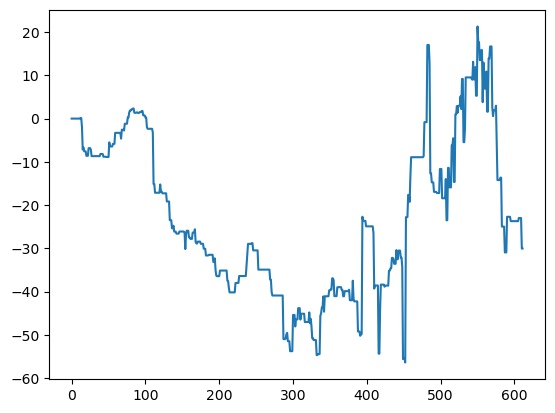

In [257]:
cumulative_returns = np.cumsum(returns)
plt.plot(cumulative_returns)
plt.savefig('/Users/hitengoel/Machine Learning/data analysis(technical indiactors)/data-analysis-with-technical-indicators/Pair Trading final/plots/without clustering/weekly/DOW JONES_macd_rsi.png', dpi=300)
plt.show()

## Strat-2 RSI

In [258]:
def get_returns1(master_macd, master_rsi, prices):
    returns = []
    intrade = []
    i = 0
    while(i<len(prices)) :
        buy = 0
        buy_rsi = 100.0
        sell = 0
        sell_rsi = 0.0
        for j in range(1,len(prices.columns)):
            if(master_rsi.iloc[i,j]<30):
                if(master_rsi.iloc[i,j]<buy_rsi):
                    buy = j
                    buy_rsi = master_rsi.iloc[i,j]
            elif(master_rsi.iloc[i,j]>70):
                if(master_rsi.iloc[i,j]>sell_rsi):
                    sell = j
                    sell_rsi = master_rsi.iloc[i,j]

        if(len(intrade)==0) :
            returns.append(0)
            
        else :
            b1 = prices.iloc[intrade[0][0],intrade[0][1]]
            s1 = prices.iloc[intrade[0][0],intrade[0][3]]
            b2 = prices.iloc[i,intrade[0][1]]
            s2 = prices.iloc[i,intrade[0][3]]
            r = (((b2-b1))*intrade[0][2]) + ((s1-s2))
            returns.append(r)
            intrade.clear()

        
        if(buy!=0 and sell!=0) :
            buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
            l = [i,buy,buy_quantity,sell]
            intrade.append(l)
        
        i = i+1

    return returns, intrade

In [259]:
returns1,intrade1 = get_returns1(master_macd, master_rsi, prices)

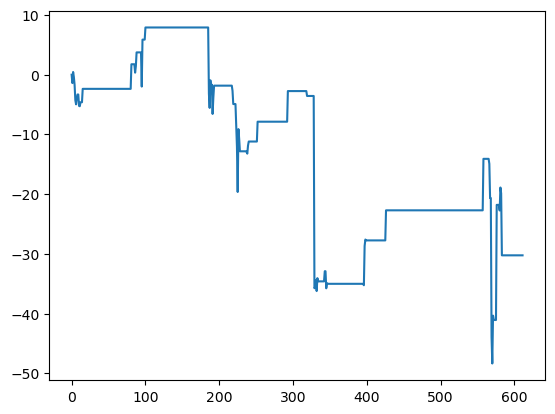

In [260]:
cumulative_returns = np.cumsum(returns1)
plt.plot(cumulative_returns)
plt.savefig('/Users/hitengoel/Machine Learning/data analysis(technical indiactors)/data-analysis-with-technical-indicators/Pair Trading final/plots/without clustering/weekly/DOW JONES_rsi.png', dpi=300)
plt.show()